# Llama Lend Extended Liquidation Example
Adapted from [@Macket](https://x.com/Macket7)'s Liquidation Demo [@curvefi/liquidation-demo](https://github.com/curvefi/liquidation-demo/)

In [1]:
import boa, os, time
import matplotlib.pyplot as plt
import pandas as pd

from dotenv import load_dotenv
from boa.explorer import fetch_abi_from_etherscan
from boa.contracts.abi.abi_contract import ABIContractFactory

%reload_ext boa.ipython

# Onchain Addresses
FACTORY_ADDR = "0xeA6876DDE9e3467564acBeE1Ed5bac88783205E0"
CRVUSD_ADDR = "0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E"
WBTC_ADDR = "0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599"
ROUTER_ADDR = "0x16C6521Dff6baB339122a0FE25a9116693265353"

# Environment Variables
load_dotenv(".env")
ETHERSCAN_API = "https://api.etherscan.io/api"
ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY") 
RPC_URL = "https://eth-mainnet.g.alchemy.com/v2/" + os.getenv("ALCHEMY_KEY")
boa.env.fork(RPC_URL)

In [2]:
# Create Users
ADMIN = boa.env.generate_address()
BORROWER = boa.env.generate_address()
TRADER = boa.env.generate_address()
LIQUIDATOR = boa.env.generate_address()

print(f"ADMIN:\t\t{ADMIN}\n\
BORROWER:\t{BORROWER}\n\
TRADER:\t\t{TRADER}\n\
LIQUIDATOR:\t{LIQUIDATOR}")

ADMIN:		0xd13f0Bd22AFF8176761AEFBfC052a7490bDe268E
BORROWER:	0xA73d7cddCf77c00827459f986bf828999B58C6Fe
TRADER:		0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B
LIQUIDATOR:	0x93f00b06693262b2A06a66F643e38B89FB2A7118


In [3]:
# Helper Functions

SLEEP_DELAY = 1

def load_from_impl(contract_addr, abi_addr, name='Unnamed'):
    abi = fetch_abi_from_etherscan(abi_addr, ETHERSCAN_API, ETHERSCAN_KEY)
    time.sleep(SLEEP_DELAY)
    return ABIContractFactory.from_abi_dict(abi, name=name).at(contract_addr)


def plot_results(trade_data):
    # Assuming trade_data is already collected in the format [trade_amount, price, health]
    columns = ['Trade Amount', 'Price', 'Borrower Health']
    df = pd.DataFrame(trade_data, columns=columns)
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create second y-axis for price
    ax2 = ax1.twinx()
    
    # Plot Trade Amounts on ax1
    ax1.plot(df.index, df['Trade Amount'], 'g-', label='Trade Amount')
    ax1.set_xlabel('Trade Step')
    ax1.set_ylabel('Trade Amount', color='g')
    ax1.tick_params('y', colors='g')
    
    # Plot Prices on ax2 with a log scale
    ax2.plot(df.index, df['Price'], 'b-', label='Price')
    ax2.set_ylabel('Price (Log Scale)', color='b')
    ax2.set_yscale('log')  # Set logarithmic scale for prices
    ax2.tick_params('y', colors='b')
    
    # Optional: Separate plot for Borrower Health for clarity
    fig2, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(df.index, df['Borrower Health'], 'r-', label='Borrower Health')
    ax3.set_xlabel('Trade Step')
    ax3.set_ylabel('Borrower Health', color='r')
    ax3.tick_params('y', colors='r')
    
    # Add gridlines
    ax1.grid(True)
    ax3.grid(True)
    
    # Add titles
    plt.title('Trade Data: Trade Amounts, Prices, and Borrower Health Over Time')
    
    # Show both plots
    fig.tight_layout()  # Adjust layout for a cleaner look
    fig2.tight_layout()
    plt.show()


def plot_user(amm, user):
    bands = range(
        min(0, amm.active_band(), amm.read_user_tick_numbers(user)[0]),
        max(amm.active_band(), amm.read_user_tick_numbers(user)[1]) + 1,
    )
    
    p_min = [amm.p_oracle_down(n) for n in bands]
    p_max = [amm.p_oracle_up(n) for n in bands]
    y_values = [amm.bands_y(n) for n in bands]

    fig, ax = plt.subplots(figsize=(12, 6))
    grey_cmap = plt.colormaps["Greys"]

    for i, (min_val, max_val, y_val) in enumerate(zip(p_min, p_max, y_values)):
        width = max_val - min_val

        if bands[i] == amm.active_band():
            color = "green"
            edge_color = "darkgreen"
        else:
            # Use different shades of grey for non-active bands
            color = grey_cmap(0.3 + (i / len(bands)) * 0.5)
            edge_color = grey_cmap(0.5 + (i / len(bands)) * 0.5)

        rect = plt.Rectangle(
            (min_val, 0),
            width,
            y_val,
            fill=True,
            facecolor=color,
            alpha=0.3,
            edgecolor=edge_color,
            linewidth=0.5,
        )
        ax.add_patch(rect)

        # Add horizontal line for y_val = 0 cases
        ax.plot([min_val, max_val], [y_val, y_val], color=edge_color, linewidth=2)

    # Price line
    ax.axvline(
        x=oracle.price(), color="red", linestyle="-", linewidth=2, label="Oracle Price"
    )
    ax.axvline(
        x=amm.price_oracle(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label="AMM Price",
    )

    # Lavels
    ax.set_xlabel("Price (p)")
    ax.set_ylabel("Collateral")
    ax.set_title(f"Price Range and Collateral for User {user}")
    ax.legend()

    # Plot
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()


def plot_user_state(state_wbtc, state_crvusd, debt, oracle_price_wbtc):
    # Convert state_wbtc to crvUSD equivalent value using the oracle price
    state_wbtc_value = state_wbtc * oracle_price_wbtc
    
    # Stack values for unhealthy user state
    unhealthy_values = [state_wbtc_value, state_crvusd]
    labels = ['WBTC (USD)', 'crvUSD']
 
    # Adjusting the figure size to allow for better spacing and keep font sizes readable
    fig, ax = plt.subplots(figsize=(12, 6))  # Larger figure size
    
    # Plot the stacked bar for unhealthy user state
    bar_wbtc = ax.bar("Unhealthy State", unhealthy_values[0], label='WBTC (USD)', color='orange')
    bar_crvusd = ax.bar("Unhealthy State", unhealthy_values[1], bottom=unhealthy_values[0], label='crvUSD', color='green')
    
    # Plot the debt bar
    bar_debt = ax.bar("Debt", debt, label='Debt', color='red')
    
    # Label each bar with its dollar value
    for bar in bar_wbtc:
        height = bar.get_height()
        ax.annotate(f'{state_wbtc:,.4f} WBTC @ ${oracle_price_wbtc:,.0f} \n = ${height:,.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)
    
    for bar in bar_crvusd:
        height = bar.get_height() + unhealthy_values[0]
        ax.annotate(f'{unhealthy_values[1]:,.2f} $crvUSD collateral', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)
    
    for bar in bar_debt:
        height = bar.get_height()
        ax.annotate(f'{height:,.2f} $crvUSD Debt', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=11)
    
    # Add labels and title
    ax.set_ylabel("USD Value")
    ax.set_title("Unhealthy User State vs Debt (with Dollar Values)")
    
    # Move the legend to the upper left to avoid overlap with the labels
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout to prevent the top label from being cut off
    plt.tight_layout()
    
    # Display the plot
    plt.show()

## ADMIN deploys dummy oracle

In [4]:
%%vyper dummy_oracle

price: public(uint256)
ADMIN: immutable(address)

@external
def __init__(admin: address, price: uint256):
    self.price = price
    ADMIN = admin

@external
def price_w() -> uint256:
    # State-changing price oracle in case we want to include EMA
    return self.price

@external
def set_price(price: uint256):
    assert msg.sender == ADMIN
    self.price = price

In [5]:
with boa.env.prank(ADMIN):
    oracle = dummy_oracle.deploy(boa.env.eoa, 65_000 * 10**18)
    
print(
    f"Dummy oracle deployed to {oracle.address} with oracle price of {oracle.price_w() / 10**18:,.0f}"
)

Dummy oracle deployed to 0xC6Acb7D16D51f72eAA659668F30A40d87E2E0551 with oracle price of 65,000


## ADMIN creates Llama Lend Vault

In [6]:
A = 75
fee = int(.15 * 1e16)                   # 15 bps
loan_discount = int(6.5 * 1e16)         # 6.5 %
liquidation_discount = int(3.5 * 1e16)  # 3.5 %

factory = boa.from_etherscan(FACTORY_ADDR, "Factory", ETHERSCAN_API, ETHERSCAN_KEY)

with boa.env.prank(ADMIN):
    vault_address = factory.create(
        CRVUSD_ADDR,
        WBTC_ADDR,
        A,
        fee,
        loan_discount,
        liquidation_discount,
        oracle.address,
        "WBTC Long Example",
    )

vault = load_from_impl(vault_address, factory.vault_impl(), "VaultMock")
controller = load_from_impl(vault.controller(), factory.controller_impl(), "ControllerMock")
amm = load_from_impl(vault.amm(), factory.amm_impl(), "AMMMock")

print(f"VAULT:\t\t{vault.address}\n\
CONTROLLER:\t{controller.address}\n\
AMM:\t\t{amm.address}")

VAULT:		0xe9cA32785e192abD1bcF4e9fa0160Dc47E93ED89
CONTROLLER:	0x36a95FE7C49170826763868900F56b2674aDb7d2
AMM:		0x5d4a335b613C4d954D77e0ec59612BeF846741fd


## ADMIN deposits $crvUSD to the new Llama Lend vault

In [7]:
# Supply ADMIN with crvUSD
crvusd = boa.from_etherscan(CRVUSD_ADDR, "crvUSD", ETHERSCAN_API, ETHERSCAN_KEY)
supply_amount = 10_000_000 * 10**18  
crvusd.transfer(ADMIN, supply_amount, sender="0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635")  # Loot from crvUSD ETH controller

# Deposit into vault
with boa.env.prank(ADMIN):
    crvusd.approve(vault, supply_amount)
    vault.deposit(supply_amount)

print(f"Vault received {crvusd.balanceOf(controller)/10**18:,.0f} $crvUSD")

Vault received 10,000,000 $crvUSD


## BORROWER creates loan in the new Llama Lend vault

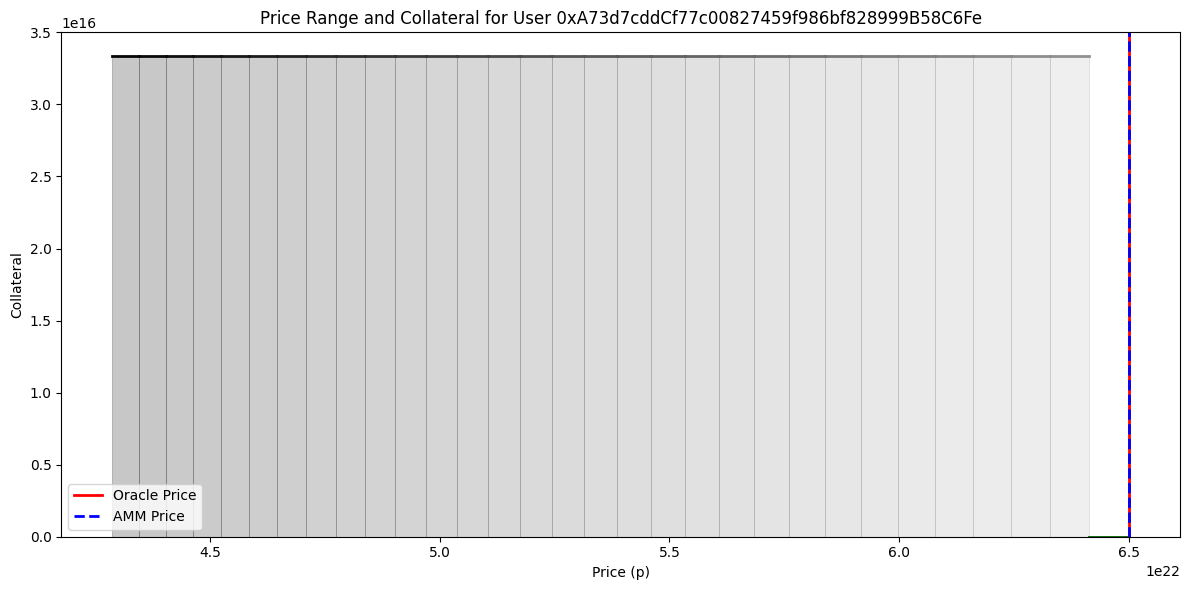

In [8]:
# Supply BORROWER with BTC
wbtc = boa.from_etherscan(WBTC_ADDR, "WBTC", ETHERSCAN_API, ETHERSCAN_KEY)
collateral_amount = 10**8  # 1 BTC
wbtc.transfer(BORROWER, collateral_amount, sender="0x5Ee5bf7ae06D1Be5997A1A72006FE6C607eC6DE8")  # Just use AAVE

# Borrow
max_borrowable = controller.max_borrowable(collateral_amount, 30)
with boa.env.prank(BORROWER):
    wbtc.approve(controller, collateral_amount)
    controller.create_loan(collateral_amount, max_borrowable, 30)

plot_user(amm, BORROWER)

## TRADER dumps and trades

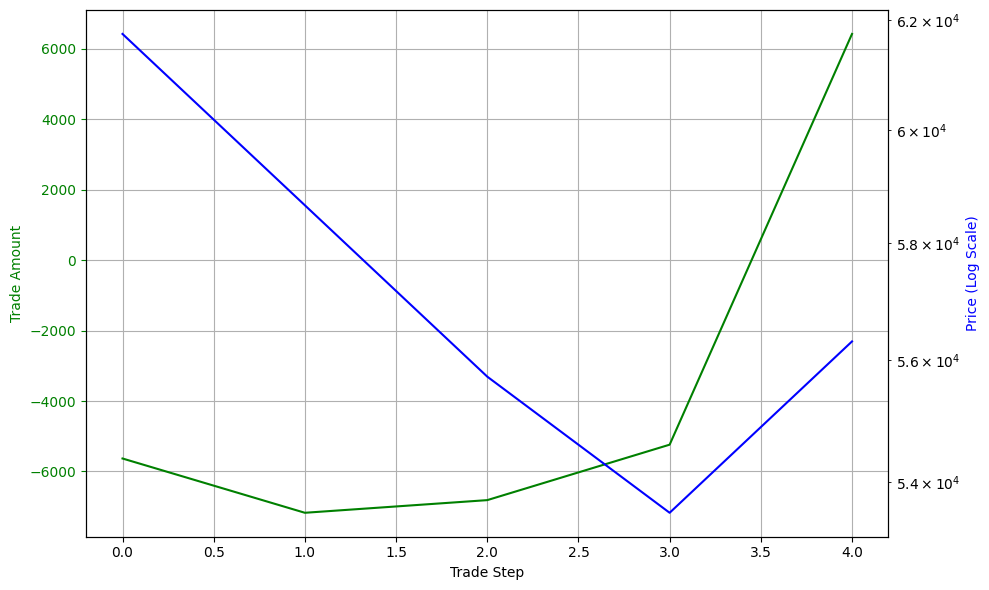

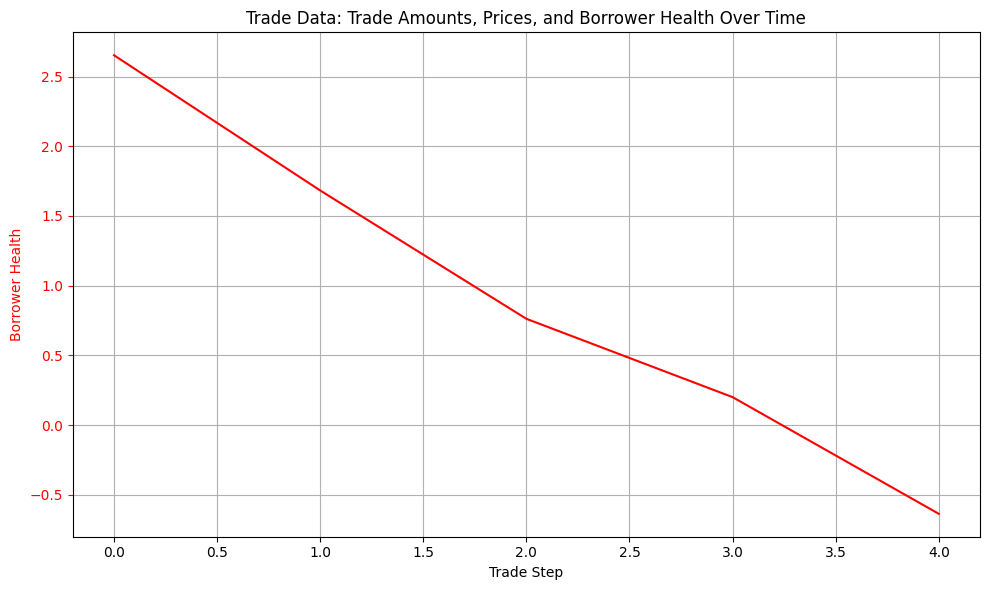

In [9]:
# Fund TRADER and set approvals
crvusd.transfer(TRADER, 100_000 * 10**18, sender="0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635")  # crvusd ETH controller
wbtc.transfer(TRADER, 10 * 10**8, sender="0x5Ee5bf7ae06D1Be5997A1A72006FE6C607eC6DE8")  # AAVE

with boa.env.prank(TRADER):
    crvusd.approve(amm, 2**256 - 1)
    wbtc.approve(amm, 2**256 - 1)

# Initialize and target price in middle of range
[p_up, p_down] = controller.user_prices(BORROWER)
p_mid = (p_up + p_down) // 2

p_o = 65_000 * 10**18
trade_data = []

# The dumping continues until BORROWER is underwater
while controller.health(BORROWER) > 0:
    
    # ADMIN sets oracle price
    if p_o == p_mid:
        p_o = p_o * 20 // 19
    elif p_o * 19 // 20 < p_mid:
        p_o = p_mid
    else:
        p_o = p_o * 19 // 20

    oracle.set_price(p_o, sender=ADMIN)

    # Fast forward
    boa.env.time_travel(seconds=600)

    # TRADER arbs the Llama Lend vault
    trade_amount, is_pump = amm.get_amount_for_price(p_o)
    i = 0  # crvUSD in
    j = 1  # WBTC out
    if not is_pump:
        mult = (p_o / 10 ** 18) / 10 ** wbtc.decimals() 
        i, j = j, i  # WBTC in and crvUSD out
    else:
        mult = -1 / 10 ** 18
    amm.exchange(i, j, trade_amount, 0, sender=TRADER)
    trade_data.append([mult * trade_amount, p_o / 10 ** 18, controller.health(BORROWER) / 10 ** 16])

plot_results(trade_data)

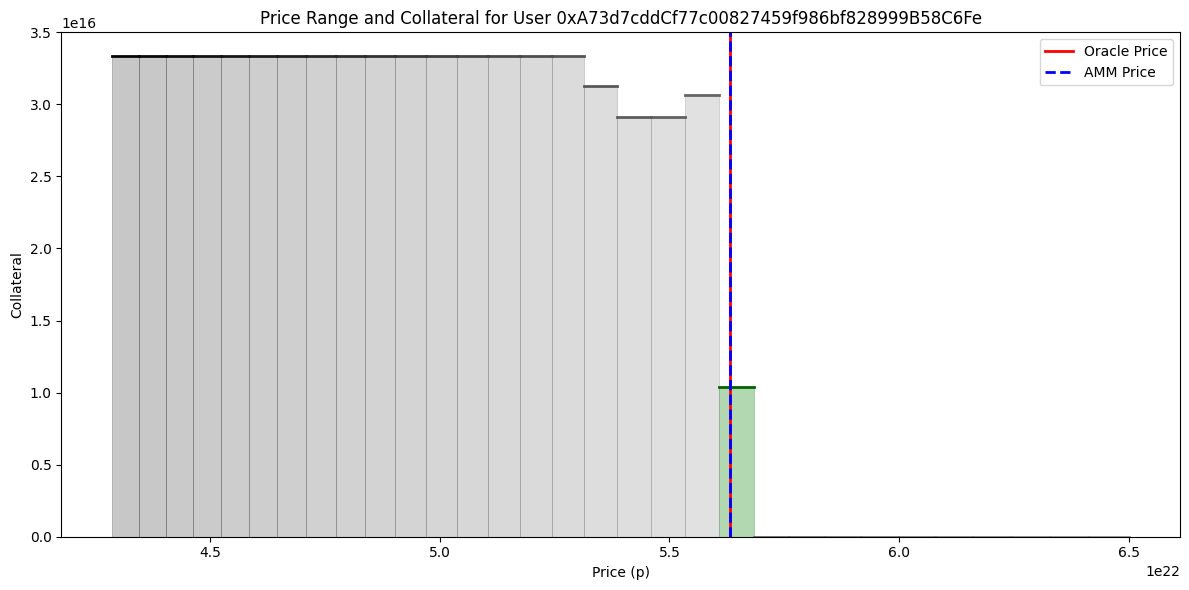

In [10]:
plot_user(amm, BORROWER)

## LIQUIDATOR runs an extended liquidation

In [11]:
%%vyper hard_liquidator_contract
# @version 0.3.10

interface ERC20:
    def transfer(_to: address, _value: uint256) -> bool: nonpayable
    def approve(_spender: address, _value: uint256) -> bool: nonpayable
    def balanceOf(_for: address) -> uint256: view
    def allowance(_owner: address, _spender: address) -> uint256: view

interface OldController:  # Has use_eth arg
    def liquidate_extended(user: address, min_x: uint256, frac: uint256, use_eth: bool, callbacker: address, callback_args: DynArray[uint256,5]): nonpayable

interface Controller:
    def liquidate_extended(user: address, min_x: uint256, frac: uint256, callbacker: address, callback_args: DynArray[uint256,5]): nonpayable
    def collateral_token() -> ERC20: view
    def borrowed_token() -> ERC20: view


ROUTER: immutable(address)

controller: Controller
calldata: Bytes[10**5]


@external
def __init__(_router: address):
    ROUTER = _router


@external
def callback_liquidate(user: address, stablecoins: uint256, collateral: uint256, debt: uint256, callback_args: DynArray[uint256, 5]) -> uint256[2]:
    assert msg.sender == self.controller.address

    collateral_token: ERC20 = self.controller.collateral_token()
    borrowed_token: ERC20 = self.controller.borrowed_token()
    if collateral_token.allowance(self, ROUTER) == 0:
        collateral_token.approve(ROUTER, max_value(uint256), default_return_value=True)
    if borrowed_token.allowance(self, self.controller.address) == 0:
        borrowed_token.approve(self.controller.address, max_value(uint256), default_return_value=True)

    raw_call(ROUTER, self.calldata)
    borrowed_amt: uint256 = borrowed_token.balanceOf(self)

    return [borrowed_amt, 0]


@external
def liquidate(user: address, min_x: uint256, frac: uint256, controller: address, calldata: Bytes[10**5], has_use_eth: bool = False, _for: address = msg.sender) -> uint256[2]:
    self.controller = Controller(controller)
    self.calldata = calldata

    if has_use_eth:
        OldController(self.controller.address).liquidate_extended(user, min_x, frac, False, self, [])
    else:
        self.controller.liquidate_extended(user, min_x, frac, self, [])

    collateral_token: ERC20 = self.controller.collateral_token()
    borrowed_token: ERC20 = self.controller.borrowed_token()
    collateral_amt: uint256 = collateral_token.balanceOf(self)
    borrowed_amt: uint256 = borrowed_token.balanceOf(self)
    if collateral_amt > 0:
        assert collateral_token.transfer(_for, collateral_amt)
    if borrowed_amt > 0:
        assert borrowed_token.transfer(_for, borrowed_amt)

    return [borrowed_amt, collateral_amt]


In [12]:
hard_liquidator = hard_liquidator_contract.deploy(ROUTER_ADDR)

Unhealthy user state: 0.66387642 WBTC, $18,169.19 crvUSD, $49,355.57 debt
Delta: $6,203.02


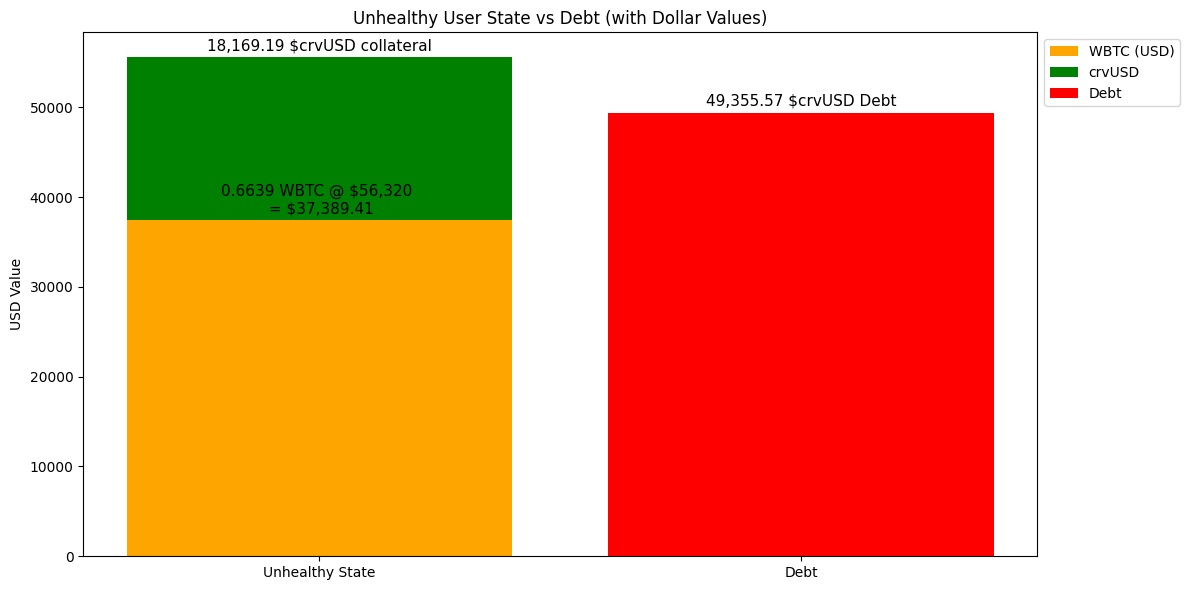

In [13]:
# Unhealthy User State
user_state = controller.user_state(BORROWER)

state_wbtc = user_state[0] / 10 ** wbtc.decimals()
state_crvusd = user_state[1] / 10 ** 18
debt = user_state[2] / 10 ** 18
wbtc_price = oracle.price_w() / 10 ** 18
print(f"Unhealthy user state: {state_wbtc} WBTC, ${state_crvusd:,.2f} crvUSD, ${debt:,.2f} debt")
print(f"Delta: ${state_wbtc * wbtc_price + state_crvusd - debt:,.2f}")
plot_user_state(state_wbtc, state_crvusd, debt, wbtc_price)

In [14]:
# Need to sell WBTC to liquidate
SWAP_DATA = {
    "route": [
        "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599",  # WBTC
        "0xf5f5b97624542d72a9e06f04804bf81baa15e2b4",  # TricryptoUSDT pool
        "0xdac17f958d2ee523a2206206994597c13d831ec7",  # USDT
        "0x390f3595bca2df7d23783dfd126427cceb997bf4",  # crvUSD/USDT pool
        "0xf939e0a03fb07f59a73314e73794be0e57ac1b4e",  # crvUSD
    ] + ["0x0000000000000000000000000000000000000000"] * 6,
    "swap_params": [[1, 0, 1, 30, 3], [0, 1, 1, 1, 2]] + [[0, 0, 0, 0, 0]] * 3,
    "pools": [
         "0xf5f5b97624542d72a9e06f04804bf81baa15e2b4",  # TricryptoUSDT pool
         "0x390f3595bca2df7d23783dfd126427cceb997bf4",  # crvUSD/USDT pool
     ] + ["0x0000000000000000000000000000000000000000"] * 3
}

curve_router = boa.from_etherscan(ROUTER_ADDR, "Router", ETHERSCAN_API, ETHERSCAN_KEY)

tokens_to_liquidate = user_state[2] - user_state[1]
print(f"Tokens to liquidate: {tokens_to_liquidate / 10 ** 18:,.2f} $crvUSD")

wbtc_required = curve_router.get_dx(SWAP_DATA["route"], SWAP_DATA["swap_params"], tokens_to_liquidate, SWAP_DATA["pools"])
wbtc_to_sell = wbtc_required * 100 // 99
wbtc_formatted = wbtc_to_sell / 10 ** wbtc.decimals()
wbtc_price = oracle.price_w() / 10 ** 18
print(f"WBTC to sell: {wbtc_formatted} WBTC @ ${wbtc_price:,.2f} ~= ${wbtc_formatted * wbtc_price:,.2f}")

expected = curve_router.get_dy(SWAP_DATA["route"], SWAP_DATA["swap_params"], wbtc_to_sell)
calldata = curve_router.exchange.prepare_calldata(SWAP_DATA["route"], SWAP_DATA["swap_params"], wbtc_to_sell, expected * 999 // 1000)
print(f"Expected: ${expected / 10 ** 18:,.2f} crvUSD")

Tokens to liquidate: 31,186.39 $crvUSD
WBTC to sell: 0.50794202 WBTC @ $56,319.83 ~= $28,607.21
Expected: $31,500.78 crvUSD


In [15]:
# Perform Liquidation
print(f"Liquidator initial balances: {wbtc.balanceOf(LIQUIDATOR)} WBTC, ${crvusd.balanceOf(LIQUIDATOR)} crvUSD")
hard_liquidator.liquidate(BORROWER, user_state[1] * 999 // 1000, 10**18, controller, calldata, sender=LIQUIDATOR)
print("\nEXTENDED LIQUIDATION HAPPENED!!!\n")

liq_wbtc = wbtc.balanceOf(LIQUIDATOR) / 10 ** wbtc.decimals()
liq_crvusd = crvusd.balanceOf(LIQUIDATOR) / 10 ** 18
print(f"Liquidator balances: {liq_wbtc} WBTC, ${liq_crvusd:.2f} crvUSD")
print(f"Liquidator value: ${liq_wbtc * wbtc_price + liq_crvusd:,.2f}")

Liquidator initial balances: 0 WBTC, $0 crvUSD

EXTENDED LIQUIDATION HAPPENED!!!

Liquidator balances: 0.1559344 WBTC, $314.39 crvUSD
Liquidator value: $9,096.59


Liquidated user state: 0 WBTC, $0 crvUSD, $0 debt


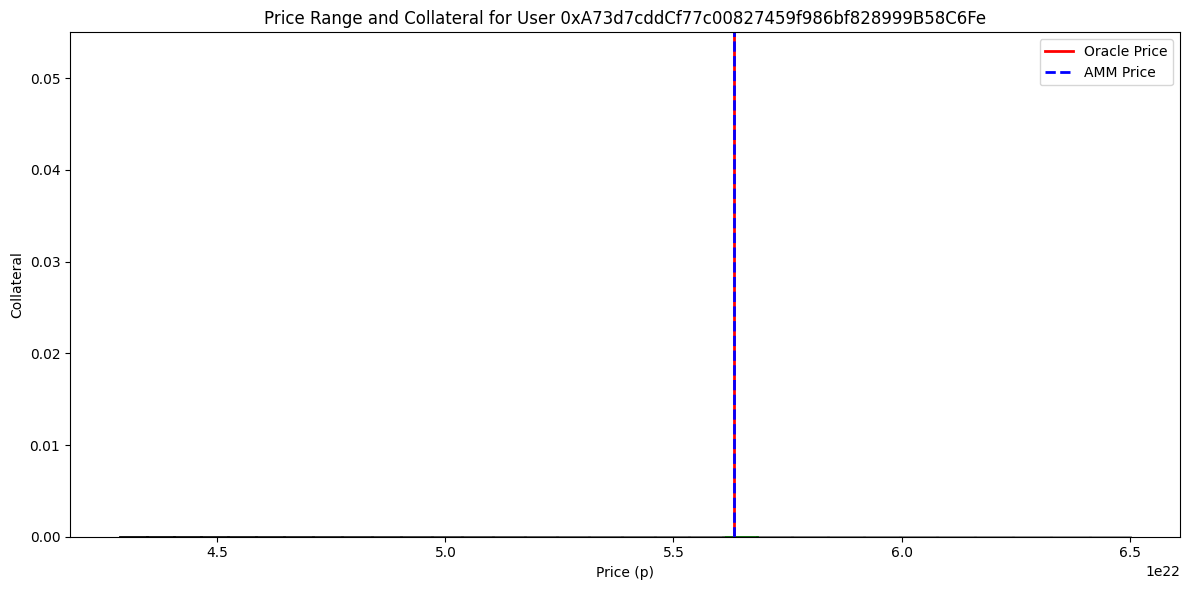

In [16]:
# Final User State
state_wbtc, state_crvusd, debt, N = controller.user_state(BORROWER)
print(f"Liquidated user state: {state_wbtc} WBTC, ${state_crvusd} crvUSD, ${debt} debt")

plot_user(amm, BORROWER)